# Lab 4: Data Imputation using an Autoencoder

**Deadline**: Mon, March 01, 5:00pm

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**TA**: Chris Lucasius <christopher.lucasius@mail.utoronto.ca>

In this lab, you will build and train an autoencoder to impute (or "fill in") missing data. 

We will be using the
Adult Data Set provided by the UCI Machine Learning Repository [1], available 
at https://archive.ics.uci.edu/ml/datasets/adult.
The data set contains census record files of adults, including their
age, martial status, the type of work they do, and other features. 

Normally, people use this data set to build a supervised classification
model to classify whether a person is a high income earner.
We will not use the dataset for this original intended purpose.

Instead, we will perform the task of imputing (or "filling in") missing values in the dataset. For example,
we may be missing one person's martial status, and another person's age, and
a third person's level of education. Our model will predict the missing features 
based on the information that we do have about each person.

We will use a variation of a denoising autoencoder to solve this data imputation
problem. Our autoencoder will be trained using inputs that have one categorical feature artificially
removed, and the goal of the autoencoder is to correctly reconstruct all features,
including the one removed from the input.

In the process, you are expected to learn to:

1. Clean and process continuous and categorical data for machine learning.
2. Implement an autoencoder that takes continuous and categorical (one-hot) inputs.
3. Tune the hyperparameters of an autoencoder.
4. Use baseline models to help interpret model performance.

[1] Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.


### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information (.html files are also acceptable).

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.


## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://drive.google.com/file/d/1Qnb3tdN8Ioeh03hPGnUC5646XXy5ptb8/view?usp=sharing

In [1]:
import csv
import time
import numpy as np
import random
import torch
import torch.utils.data
from torch.autograd import Variable
import matplotlib.pyplot as plt

## Part 0

We will be using a package called `pandas` for this assignment. 

If you are using Colab, `pandas` should already be available.
If you are using your own computer,
installation instructions for `pandas` are available here: 
https://pandas.pydata.org/pandas-docs/stable/install.html

In [2]:
import pandas as pd

# Part 1. Data Cleaning [15 pt]

The adult.data file is available at `https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data`

The function `pd.read_csv` loads the adult.data file into a pandas dataframe.
You can read about the pandas documentation for `pd.read_csv` at
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [3]:
header = ['age', 'work', 'fnlwgt', 'edu', 'yredu', 'marriage', 'occupation',
 'relationship', 'race', 'sex', 'capgain', 'caploss', 'workhr', 'country']
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=header,
    index_col=False)

In [4]:
df.shape # there are 32561 rows (records) in the data frame, and 14 columns (features)

(32561, 14)

### Part (a) Continuous Features [3 pt]

For each of the columns `["age", "yredu", "capgain", "caploss", "workhr"]`, report the minimum, maximum, and average value across the dataset. 

Then, normalize each of the features `["age", "yredu", "capgain", "caploss", "workhr"]`
so that their values are always between 0 and 1.
Make sure that you are actually modifying the dataframe `df`. 

Like numpy arrays and torch tensors, 
pandas data frames can be sliced. For example, we can
display the first 3 rows of the data frame (3 records) below.

In [5]:
df[:3] # show the first 3 records

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States


Alternatively, we can slice based on column names, 
for example `df["race"]`, `df["hr"]`, or even index multiple columns 
like below.

In [6]:
subdf = df[["age", "yredu", "capgain", "caploss", "workhr"]]
subdf[:3] # show the first 3 records

,age,yredu,capgain,caploss,workhr
0,39,13,2174,0,40
1,50,13,0,0,13
2,38,9,0,0,40


Numpy works nicely with pandas, like below:

In [7]:
np.sum(subdf["caploss"])

2842700

Just like numpy arrays, you can modify
entire columns of data rather than one scalar element at a time.
For example, the code  

`df["age"] = df["age"] + 1` 

would increment everyone's age by 1.

In [8]:
cols = ["age", "yredu", "capgain", "caploss", "workhr"]

# normalize between 0 and 1
def normalize(data, cat):
  return (data[cat] - data[cat].min())/(data[cat].max() - data[cat].min())

for cat in cols:
  df[cat] = normalize(df, cat)

print(df)

            age               work  fnlwgt  ... caploss    workhr         country
0      0.301370          State-gov   77516  ...     0.0  0.397959   United-States
1      0.452055   Self-emp-not-inc   83311  ...     0.0  0.122449   United-States
2      0.287671            Private  215646  ...     0.0  0.397959   United-States
3      0.493151            Private  234721  ...     0.0  0.397959   United-States
4      0.150685            Private  338409  ...     0.0  0.397959            Cuba
...         ...                ...     ...  ...     ...       ...             ...
32556  0.136986            Private  257302  ...     0.0  0.377551   United-States
32557  0.315068            Private  154374  ...     0.0  0.397959   United-States
32558  0.561644            Private  151910  ...     0.0  0.397959   United-States
32559  0.068493            Private  201490  ...     0.0  0.193878   United-States
32560  0.479452       Self-emp-inc  287927  ...     0.0  0.397959   United-States

[32561 rows x 1

### Part (b) Categorical Features [1 pt]

What percentage of people in our data set are male? Note that the data labels all have an unfortunate space in the beginning, e.g. " Male" instead of "Male".

What percentage of people in our data set are female?

In [9]:
# hint: you can do something like this in pandas
sum(df["sex"] == " Male")

print("Male percentage =", sum(df["sex"] == " Male")/len(df["sex"]))
print("Female percentage =", sum(df["sex"] == " Female")/len(df["sex"]))

Male percentage = 0.6692054912318418
Female percentage = 0.33079450876815825


### Part (c) [2 pt]

Before proceeding, we will modify our data frame in a couple more ways:

1. We will restrict ourselves to using a subset of the features (to simplify our autoencoder)
2. We will remove any records (rows) already containing missing values, and store them in a second dataframe. We will only use records without missing values to train our autoencoder.

Both of these steps are done for you, below.

How many records contained missing features? What percentage of records were removed?

In [10]:
contcols = ["age", "yredu", "capgain", "caploss", "workhr"]
catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"]
features = contcols + catcols
df = df[features]

In [11]:
missing = pd.concat([df[c] == " ?" for c in catcols], axis=1).any(axis=1)
df_with_missing = df[missing]
df_not_missing = df[~missing]

print("Records with missing features =", len(df_with_missing))
print("Percentage of records with missing features =", len(df_with_missing)/len(df))

Records with missing features = 1843
Percentage of records with missing features = 0.056601455729246644


### Part (d) One-Hot Encoding [1 pt]

What are all the possible values of the feature "work" in `df_not_missing`? You may find the Python function `set` useful.

In [12]:
set(df_not_missing['work'])

{' Federal-gov',
 ' Local-gov',
 ' Private',
 ' Self-emp-inc',
 ' Self-emp-not-inc',
 ' State-gov',
 ' Without-pay'}

We will be using a one-hot encoding to represent each of the categorical variables.
Our autoencoder will be trained using these one-hot encodings.

We will use the pandas function `get_dummies` to produce one-hot encodings
for all of the categorical variables in `df_not_missing`. 

In [13]:
data = pd.get_dummies(df_not_missing)

In [14]:
data[:3]

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,work_ State-gov,work_ Without-pay,marriage_ Divorced,marriage_ Married-AF-spouse,marriage_ Married-civ-spouse,marriage_ Married-spouse-absent,marriage_ Never-married,marriage_ Separated,marriage_ Widowed,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,edu_ 10th,edu_ 11th,edu_ 12th,edu_ 1st-4th,edu_ 5th-6th,edu_ 7th-8th,edu_ 9th,edu_ Assoc-acdm,edu_ Assoc-voc,edu_ Bachelors,edu_ Doctorate,edu_ HS-grad,edu_ Masters,edu_ Preschool,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.301370,0.800000,0.02174,0.0,0.397959,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,0.452055,0.800000,0.00000,0.0,0.122449,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,0.287671,0.533333,0.00000,0.0,0.397959,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1


### Part (e) One-Hot Encoding [2 pt]

The dataframe `data` contains the cleaned and normalized data that we will use to train our denoising autoencoder.

How many **columns** (features) are in the dataframe `data`?

Briefly explain where that number come from.

In [15]:
# data contains datum that are one-hot encoded to all of the possible features 
# (which are the columns of the data, or the keys if you're considering it as a)
# dictionary). The columns represent all of the possible features each datum
# can take. 

len(data.keys())

57

### Part (f) One-Hot Conversion [3 pt]

We will convert the pandas data frame `data` into numpy, so that
it can be further converted into a PyTorch tensor.
However, in doing so, we lose the column label information that
a panda data frame automatically stores.

Complete the function `get_categorical_value` that will return
the named value of a feature given a one-hot embedding.
You may find the global variables `cat_index` and `cat_values`
useful. (Display them and figure out what they are first.)

We will need this function in the next part of the lab
to interpret our autoencoder outputs. So, the input
to our function `get_categorical_values` might not 
actually be "one-hot" -- the input may instead 
contain real-valued predictions from our neural network.

In [16]:
datanp = data.values.astype(np.float32)

In [17]:
cat_index = {}  # Mapping of feature -> start index of feature in a record
cat_values = {} # Mapping of feature -> list of categorical values the feature can take

# build up the cat_index and cat_values dictionary
for i, header in enumerate(data.keys()):
    if "_" in header: # categorical header
        feature, value = header.split()
        feature = feature[:-1] # remove the last char; it is always an underscore
        if feature not in cat_index:
            cat_index[feature] = i
            cat_values[feature] = [value]
        else:
            cat_values[feature].append(value)

def get_onehot(record, feature):
    """
    Return the portion of `record` that is the one-hot encoding
    of `feature`. For example, since the feature "work" is stored
    in the indices [5:12] in each record, calling `get_range(record, "work")`
    is equivalent to accessing `record[5:12]`.
    
    Args:
        - record: a numpy array representing one record, formatted
                  the same way as a row in `data.np`
        - feature: a string, should be an element of `catcols`
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    return record[start_index:stop_index]

def get_categorical_value(onehot, feature):
    """
    Return the categorical value name of a feature given
    a one-hot vector representing the feature.
    
    Args:
        - onehot: a numpy array one-hot representation of the feature
        - feature: a string, should be an element of `catcols`
        
    Examples:
    
    >>> get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")
    'State-gov'
    >>> get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")
    'Private'
    """
    # <----- TODO: WRITE YOUR CODE HERE ----->
    # You may find the variables `cat_index` and `cat_values` 
    # (created above) useful.
    return cat_values[feature][np.argmax(onehot)]

print("get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), \"work\") =", get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work"))
print("get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), \"work\") =", get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work"))

get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work") = State-gov
get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work") = Private


In [18]:
# more useful code, used during training, that depends on the function
# you write above

def get_feature(record, feature):
    """
    Return the categorical feature value of a record
    """
    onehot = get_onehot(record, feature)
    return get_categorical_value(onehot, feature)

def get_features(record):
    """
    Return a dictionary of all categorical feature values of a record
    """
    return { f: get_feature(record, f) for f in catcols }

### Part (g) Train/Test Split [3 pt]

Randomly split the data into approximately 70% training, 15% validation and 15% test.

Report the number of items in your training, validation, and test set.

In [19]:
# set the numpy seed for reproducibility
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.html
np.random.seed(50)

# todo

# shuffle data
np.random.shuffle(datanp)

# calculate split indices
train_end = int(len(datanp) * 0.7)
valid_end = int(len(datanp) * (0.7 + 0.15))

train_data = datanp[:train_end]
valid_data = datanp[train_end:valid_end]
test_data = datanp[valid_end:]

print("Size of training dataset =", len(train_data))
print("Size of validation dataset =", len(valid_data))
print("Size of testing dataset =", len(test_data))

Size of training dataset = 21502
Size of validation dataset = 4608
Size of testing dataset = 4608


## Part 2. Model Setup [5 pt]

### Part (a) [4 pt]

Design a fully-connected autoencoder by modifying the `encoder` and `decoder`
below.

The input to this autoencoder will be the features of the `data`, with
one categorical feature recorded as "missing". The output of the autoencoder
should be the reconstruction of the same features, but with the missing
value filled in.

**Note**: Do not reduce the dimensionality of the input too much!
The output of your embedding is expected to contain information 
about ~11 features.

In [20]:
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self, encoding_dim=12):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(57, 24), # TODO -- FILL OUT THE CODE HERE!
            nn.ReLU(),
            nn.Linear(24, encoding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 24),
            nn.ReLU(),
            nn.Linear(24, 57), # TODO -- FILL OUT THE CODE HERE!
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Part (b) [1 pt]

Explain why there is a sigmoid activation in the last step of the decoder.

(**Note**: the values inside the data frame `data` and the training code in Part 3 might be helpful.)

In [21]:
# The sigmoid function is used to scale the output between 0 and 1, since the
# ReLU does not clip the outputs. This interprets the images to be a gray-scale
# image where each pixel stores the pixel intensity from 0 to 1. 

## Part 3. Training [18] 

### Part (a) [6 pt]

We will train our autoencoder in the following way:

- In each iteration, we will hide one of the categorical features using the `zero_out_random_features` function
- We will pass the data with one missing feature through the autoencoder, and obtain a reconstruction
- We will check how close the reconstruction is compared to the original data -- including the value of the missing feature

Complete the code to train the autoencoder, and plot the training and validation loss every few iterations.
You may also want to plot training and validation "accuracy" every few iterations, as we will define in
part (b). You may also want to checkpoint your model every few iterations or epochs.

Use `nn.MSELoss()` as your loss function. (Side note: you might recognize that this loss function is not
ideal for this problem, but we will use it anyway.)

In [22]:
def zero_out_feature(records, feature):
    """ Set the feature missing in records, by setting the appropriate
    columns of records to 0
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    records[:, start_index:stop_index] = 0
    return records

def zero_out_random_feature(records):
    """ Set one random feature missing in records, by setting the 
    appropriate columns of records to 0
    """
    return zero_out_feature(records, random.choice(catcols))

def train(model, train_data, valid_data, batch_size=64, num_epochs=20, learning_rate=1e-4, plot=False):
    """ Training loop. You should update this."""
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    # generate DataLoader objects
    train_loader = torch.utils.data.DataLoader(train_data, 
                                               batch_size=batch_size)
    valid_loader = torch.utils.data.DataLoader(valid_data, 
                                               batch_size=batch_size)
    
    # for plotting
    epochs, train_losses, valid_losses, train_acc, valid_acc = [], [], [], [], []

    # start timing
    start_time = time.time()
    for epoch in range(num_epochs):
        for data in train_loader:
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            
            recon = model(datam)
            train_loss = criterion(recon, data)
            train_loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        for data in valid_loader:
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            valid_loss = criterion(recon, data)

        epochs.append(epoch)
        train_losses.append(train_loss.item())
        valid_losses.append(valid_loss.item())
        train_acc.append(get_accuracy(model, train_loader))
        valid_acc.append(get_accuracy(model, valid_loader))

        print("Epoch {}/{}: Training Loss = {}, Validation Loss = {}".format(epoch + 1, 
                                                                             num_epochs, 
                                                                             train_losses[epoch], 
                                                                             valid_losses[epoch]))

    if plot:
        # plotting
        plt.title("Training Curve")
        plt.plot(epochs, train_losses, label="Train")
        plt.plot(epochs, valid_losses, label="Validation")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.show()

        plt.title("Training Curve")
        plt.plot(epochs, train_acc, label="Train")
        plt.plot(epochs, valid_acc, label="Validation")
        plt.xlabel("Epochs")
        plt.ylabel("Training Accuracy")
        plt.legend(loc='best')
        plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(valid_acc[-1]))

    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

### Part (b) [3 pt]

While plotting training and validation loss is valuable, loss values are harder to compare
than accuracy percentages. It would be nice to have a measure of "accuracy" in this problem.

Since we will only be imputing missing categorical values, we will define an accuracy measure.
For each record and for each categorical feature, we determine whether
the model can predict the categorical feature given all the other features of the record.

A function `get_accuracy` is written for you. It is up to you to figure out how to
use the function. **You don't need to submit anything in this part.**
To earn the marks, correctly plot the training and validation accuracy every few 
iterations as part of your training curve.

In [23]:
def get_accuracy(model, data_loader):
    """Return the "accuracy" of the autoencoder model across a data set.
    That is, for each record and for each categorical feature, 
    we determine whether the model can successfully predict the value
    of the categorical feature given all the other features of the 
    record. The returned "accuracy" measure is the percentage of times 
    that our model is successful.
        
    Args:
       - model: the autoencoder model, an instance of nn.Module
       - data_loader: an instance of torch.utils.data.DataLoader

    Example (to illustrate how get_accuracy is intended to be called.
             Depending on your variable naming this code might require
             modification.)

        >>> model = AutoEncoder()
        >>> vdl = torch.utils.data.DataLoader(data_valid, batch_size=256, shuffle=True)
        >>> get_accuracy(model, vdl)
    """
    total = 0
    acc = 0
    for col in catcols:
        for item in data_loader: # minibatches
            inp = item.detach().numpy()
            out = model(zero_out_feature(item.clone(), col)).detach().numpy()
            for i in range(out.shape[0]): # record in minibatch
                acc += int(get_feature(out[i], col) == get_feature(inp[i], col))
                total += 1
    return acc / total

### Part (c) [4 pt]

Run your updated training code, using reasonable initial hyperparameters.

Include your training curve in your submission.

Epoch 1/20: Training Loss = 0.16591590642929077, Validation Loss = 0.16740357875823975
Epoch 2/20: Training Loss = 0.07296857982873917, Validation Loss = 0.0775018259882927
Epoch 3/20: Training Loss = 0.06969495862722397, Validation Loss = 0.07321673631668091
Epoch 4/20: Training Loss = 0.06855739653110504, Validation Loss = 0.07205388695001602
Epoch 5/20: Training Loss = 0.06695717573165894, Validation Loss = 0.07078254967927933
Epoch 6/20: Training Loss = 0.06156821548938751, Validation Loss = 0.06698571890592575
Epoch 7/20: Training Loss = 0.058431629091501236, Validation Loss = 0.0591568797826767
Epoch 8/20: Training Loss = 0.056219425052404404, Validation Loss = 0.05636307969689369
Epoch 9/20: Training Loss = 0.054941896349191666, Validation Loss = 0.05533255264163017
Epoch 10/20: Training Loss = 0.054507941007614136, Validation Loss = 0.05551234632730484
Epoch 11/20: Training Loss = 0.05409836024045944, Validation Loss = 0.05400913208723068
Epoch 12/20: Training Loss = 0.05341935

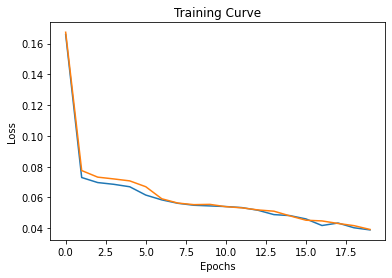

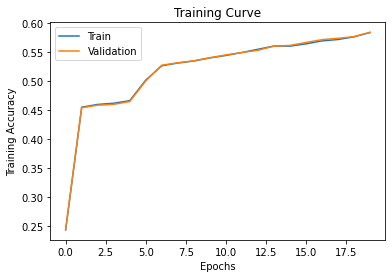

Final Training Accuracy: 0.5837286453973274
Final Validation Accuracy: 0.5842737268518519
Total time elapsed: 70.71 seconds


In [24]:
AEModel = AutoEncoder()
train(AEModel, train_data, valid_data, plot=True)

### Part (d) [5 pt]

Tune your hyperparameters, training at least 4 different models (4 sets of hyperparameters).

Do not include all your training curves. Instead, explain what hyperparameters
you tried, what their effect was, and what your thought process was as you 
chose the next set of hyperparameters to try.

In [25]:
# Double batch size and learning rate

# Accuracy was slightly higher (around +1%), and marginally lower final losses
# Training was faster from default by around 15 seconds
AEModel = AutoEncoder()
train(AEModel, train_data, valid_data, batch_size=128, learning_rate=2e-4)

Epoch 1/20: Training Loss = 0.16346748173236847, Validation Loss = 0.16762660443782806
Epoch 2/20: Training Loss = 0.0719723179936409, Validation Loss = 0.07627186179161072
Epoch 3/20: Training Loss = 0.0687456950545311, Validation Loss = 0.07314417511224747
Epoch 4/20: Training Loss = 0.06810194998979568, Validation Loss = 0.0721912607550621
Epoch 5/20: Training Loss = 0.06692966818809509, Validation Loss = 0.0705607682466507
Epoch 6/20: Training Loss = 0.06410792469978333, Validation Loss = 0.06794792413711548
Epoch 7/20: Training Loss = 0.05423459783196449, Validation Loss = 0.058214977383613586
Epoch 8/20: Training Loss = 0.05402211844921112, Validation Loss = 0.05673673748970032
Epoch 9/20: Training Loss = 0.05158393457531929, Validation Loss = 0.055656798183918
Epoch 10/20: Training Loss = 0.05250268056988716, Validation Loss = 0.05495161935687065
Epoch 11/20: Training Loss = 0.04955671355128288, Validation Loss = 0.05325838550925255
Epoch 12/20: Training Loss = 0.047923911362886

In [26]:
# Halve batch size and learning rate

# Since doubling batch size and learning rate didn't seem to change much, I
# tried to lower both the batch size and learning rate instead. I assumed that
# increasing either the batch size or the learning rate would have no further
# effect in improving the model, so maybe lowering them might affect it.

# Slightly worse performance (around -1%), higher final losses
# Training was slower from default by around 23 seconds
AEModel = AutoEncoder()
train(AEModel, train_data, valid_data, batch_size=32, learning_rate=5e-5)

Epoch 1/20: Training Loss = 0.149537593126297, Validation Loss = 0.1538858562707901
Epoch 2/20: Training Loss = 0.07148543000221252, Validation Loss = 0.07596873492002487
Epoch 3/20: Training Loss = 0.06731489300727844, Validation Loss = 0.07260928303003311
Epoch 4/20: Training Loss = 0.06637094914913177, Validation Loss = 0.07176454365253448
Epoch 5/20: Training Loss = 0.06586606800556183, Validation Loss = 0.07094256579875946
Epoch 6/20: Training Loss = 0.06467179954051971, Validation Loss = 0.06965554505586624
Epoch 7/20: Training Loss = 0.06005288287997246, Validation Loss = 0.06444201618432999
Epoch 8/20: Training Loss = 0.05417368933558464, Validation Loss = 0.05880586802959442
Epoch 9/20: Training Loss = 0.05305483937263489, Validation Loss = 0.05521361157298088
Epoch 10/20: Training Loss = 0.05202056095004082, Validation Loss = 0.05331887677311897
Epoch 11/20: Training Loss = 0.05005960911512375, Validation Loss = 0.05233590677380562
Epoch 12/20: Training Loss = 0.0484793670475

In [27]:
# Smaller embedding space

# Since changing either the batch size or the learning rate had no real
# improvement on the model, changing the architecture, most notably the
# embedding space, might make a difference.

# Worse accuracy (around -1%), higher final losses
# Training was faster from default by around 3 seconds
AEModel = AutoEncoder(encoding_dim=8)
train(AEModel, train_data, valid_data)

Epoch 1/20: Training Loss = 0.18215914070606232, Validation Loss = 0.18173940479755402
Epoch 2/20: Training Loss = 0.07612505555152893, Validation Loss = 0.08001672476530075
Epoch 3/20: Training Loss = 0.06991682201623917, Validation Loss = 0.07352472841739655
Epoch 4/20: Training Loss = 0.06836201995611191, Validation Loss = 0.07220320403575897
Epoch 5/20: Training Loss = 0.06623172014951706, Validation Loss = 0.06978733837604523
Epoch 6/20: Training Loss = 0.06118306517601013, Validation Loss = 0.06249199062585831
Epoch 7/20: Training Loss = 0.056927673518657684, Validation Loss = 0.058855090290308
Epoch 8/20: Training Loss = 0.055043552070856094, Validation Loss = 0.05670252442359924
Epoch 9/20: Training Loss = 0.05464664474129677, Validation Loss = 0.05549294129014015
Epoch 10/20: Training Loss = 0.05385430157184601, Validation Loss = 0.05494041368365288
Epoch 11/20: Training Loss = 0.05346579849720001, Validation Loss = 0.05420307070016861
Epoch 12/20: Training Loss = 0.0533317327

In [28]:
# Larger embedding space, longer epochs

# As a last resort option, I decided that the model should train for longer, and
# use a slightly larger embedding space

# Best accuracy achieved (around +2%), with lower losses
# Training was slower from default by around 30 seconds
AEModel = AutoEncoder(encoding_dim=16)
train(AEModel, train_data, valid_data, num_epochs=30)

Epoch 1/30: Training Loss = 0.14431063830852509, Validation Loss = 0.1433873027563095
Epoch 2/30: Training Loss = 0.07159591466188431, Validation Loss = 0.07541733235120773
Epoch 3/30: Training Loss = 0.06942984461784363, Validation Loss = 0.07313783466815948
Epoch 4/30: Training Loss = 0.06884865462779999, Validation Loss = 0.07270399481058121
Epoch 5/30: Training Loss = 0.06829750537872314, Validation Loss = 0.07220974564552307
Epoch 6/30: Training Loss = 0.06782728433609009, Validation Loss = 0.07184953987598419
Epoch 7/30: Training Loss = 0.06667886674404144, Validation Loss = 0.07110888510942459
Epoch 8/30: Training Loss = 0.06498539447784424, Validation Loss = 0.06809468567371368
Epoch 9/30: Training Loss = 0.05760210007429123, Validation Loss = 0.06124760955572128
Epoch 10/30: Training Loss = 0.05468926206231117, Validation Loss = 0.05610470101237297
Epoch 11/30: Training Loss = 0.05452042073011398, Validation Loss = 0.05468951538205147
Epoch 12/30: Training Loss = 0.05318525806

## Part 4. Testing [12 pt]

### Part (a) [2 pt]

Compute and report the test accuracy.

In [29]:
test_loader = torch.utils.data.DataLoader(test_data, 
                                           batch_size=1)
print("Test accuracy =", get_accuracy(AEModel, test_loader))

Test accuracy = 0.5990306712962963


### Part (b) [4 pt]

Based on the test accuracy alone, it is difficult to assess whether our model
is actually performing well. We don't know whether a high accuracy is due to
the simplicity of the problem, or if a poor accuracy is a result of the inherent
difficulty of the problem.

It is therefore very important to be able to compare our model to at least one
alternative. In particular, we consider a simple **baseline**
model that is not very computationally expensive. Our neural network
should at least outperform this baseline model. If our network is not much
better than the baseline, then it is not doing well.

For our data imputation problem, consider the following baseline model:
to predict a missing feature, the baseline model will look at the **most common value** of the feature in the training set. 

For example, if the feature "marriage" is missing, then this model's prediction will be the most common value for "marriage" in the training set, which happens to be "Married-civ-spouse".

What would be the test accuracy of this baseline model?


In [30]:
from collections import Counter

# seed random
np.random.seed(42)

# use df_not_missing as database for simplicity of available feature names
# split dataset randomly
indices = df_not_missing.index.to_numpy()
np.random.shuffle(indices)

most_common = {}

# training
for cat in df_not_missing.keys():
    # remember to only use the training data
    counter = Counter(df_not_missing[cat][indices[:train_end]])
    most_common[cat] = counter.most_common()[0][0]

# testing
total = 0
acc = 0
for index in indices[valid_end:]:
    # zero out one categorical feature
    cat = np.random.choice(df_not_missing.keys().to_numpy())
    # naieve reconstruction
    acc += int(df_not_missing[cat][index] == most_common[cat])
    total += 1

print("Test accuracy =", (acc / total))

Test accuracy = 0.5006510416666666


### Part (c) [1 pt]

How does your test accuracy from part (a) compared to your basline test accuracy in part (b)?

In [31]:
# The test accuracy from the autoencoder is slightly better than the baseline 
# test accuracy from the naive baseline model (around +10%). 

### Part (d) [1 pt]

Look at the first item in your test data. 
Do you think it is reasonable for a human
to be able to guess this person's education level
based on their other features? Explain.

In [32]:
# It's difficult for a human to be able to guess the person's education level 
# based on their other features. Considering that the person is working in a
# prof-specialty occupation, an educated guess would have been that he has a
# master's or PhD level of education, but he only has a bachelors. There are 
# more instances where one's features does not have a lot of clear correlation
# with the others--there are often many more factors at play, some that cannot
# be measured.

for cat in df_not_missing.keys():
    print("{}: {}".format(cat, df_not_missing[cat][valid_end]))

age: 0.2876712328767123
yredu: 0.8
capgain: 0.04064040640406404
caploss: 0.0
workhr: 0.3979591836734694
work:  Federal-gov
marriage:  Married-civ-spouse
occupation:  Prof-specialty
edu:  Bachelors
relationship:  Husband
sex:  Male


### Part (e) [2 pt]

What is your model's prediction of this person's education
level, given their other features?


In [33]:
from torch.autograd import Variable

data = pd.get_dummies(df_not_missing)
datanp = data.values.astype(np.float32)
# Only grab the first datum in the testing dataset
test_loader = torch.utils.data.DataLoader(datanp[valid_end:valid_end + 1], batch_size=1)

for data in test_loader:
  datam = zero_out_feature(data, 'edu') # zero out one categorical feature
  out = AEModel(datam).detach().numpy()
  print("Autoencoder prediction =", get_features(out[0])['edu'])

Autoencoder prediction = Some-college


### Part (f) [2 pt]

What is the baseline model's prediction
of this person's education level?

In [34]:
print("Baseline prediction =", most_common['edu'])

Baseline prediction =  HS-grad
